# AIM
- To validate preprocessing data

Created on: 21 Mar 2022

# Workspace

In [ ]:
##### MODULES
import os
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib.dates
import matplotlib.patches
import datetime as dt
import ast

## custom modules
# import sys  
# sys.path.append('../../scripts')

from import_data import *
from clean_data import *
from mappings import *
from plotting import *
from helper import *

##### OPTIONS
pd.options.mode.chained_assignment = None

# autoreload external modules after saving changes to disk
%reload_ext autoreload
%autoreload 2

##### DIRECTORIES
proj_dir = Path('.') / '..' / '..'
source_data_dir = proj_dir/'data'/'source'
clean_data_dir =  proj_dir/'data'/'clean'
viz_dir = proj_dir/'viz'

In [ ]:
import feather

# Import

In [ ]:
phqs_raw, slps_raw, metadata = import_data(source_data_dir)
df = metadata.copy()

# File membership + Add new IDs

Obtain sets of subject id

In [ ]:
subj_id_phq = set(phqs_raw['pid'])
subj_id_slp = set(slps_raw['pid'])
subj_id_meta = set(metadata['subject_id'])

len(subj_id_phq)=487
len(subj_id_slp)=461
len(subj_id_phq_slp_intersect)=436
len(subj_id_phq_slp_meta_intersect)=434
len(subj_id_all)=659


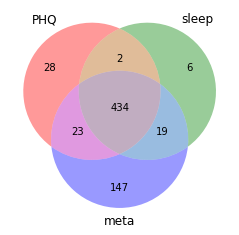

In [ ]:
subj_id_phq_slp_intersect = subj_id_phq.intersection(subj_id_slp)
subj_id_phq_slp_meta_intersect = subj_id_phq.intersection(subj_id_slp).intersection(subj_id_meta)

subj_id_all = subj_id_phq.union(subj_id_slp).union(subj_id_meta)

print(f'{len(subj_id_phq)=}')
print(f'{len(subj_id_slp)=}')
print(f'{len(subj_id_phq_slp_intersect)=}')
print(f'{len(subj_id_phq_slp_meta_intersect)=}')
print(f'{len(subj_id_all)=}')

#TODO logging

Visualize with venn diagram

In [ ]:
from matplotlib_venn import venn3_unweighted
venn3_unweighted([subj_id_phq, subj_id_slp, subj_id_meta], set_labels=('PHQ','sleep','meta'));

Any subject IDs not in the metadata file but in other files?

In [ ]:
subj_id_not_in_meta = subj_id_all.difference(subj_id_meta)
print(f'{len(subj_id_not_in_meta)=}')

len(subj_id_not_in_meta)=36


Append these 'new' IDs as additional rows of the metadata file

In [ ]:
newids = pd.DataFrame(pd.Series(list(subj_id_not_in_meta), name="subject_id"))
df2 = pd.concat([df, newids], axis=0)
df2.tail()

,ID,subject_id,human_readable_site,site_readable,flag_death,flag_covid_death,flag_suicide_death,flag_ftp_missing,flag_qr_issue,flag_fitbit_issue,...,thincit_trails_flag,thincit_pdq5_flag,android_phone_acceleration_flag,last_download_date,flag_download_in_progress,enrolment_date,withdrawal_date,in_meta,in_slp,in_phq
31,NaN,227,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,NaN,NaT,NaT,False,True,False
32,NaN,75c0267b-0944-4c19-8081-9e49eb5eadab,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,NaN,NaT,NaT,False,False,True
33,NaN,086845c3-5b0c-49af-9f05-02bdc2419fc2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,NaN,NaT,NaT,False,False,True
34,NaN,236d88c7-6995-40eb-bd45-176081cdc0de,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,NaN,NaT,NaT,False,True,True
35,NaN,784fc83c-54db-41e4-86d0-c561efad0b11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaT,NaN,NaT,NaT,False,False,True


Label the file source

In [ ]:
df2['in_meta'] = df2['subject_id'].apply(lambda x: x in subj_id_meta)
df2['in_slp'] = df2['subject_id'].apply(lambda x: x in subj_id_slp)
df2['in_phq'] = df2['subject_id'].apply(lambda x: x in subj_id_phq)

There are some weird subject IDs e.g. '207' that are new to the metadata file. Subject ids are expected to be 36 characters long

In [ ]:
show = df2[['ID', 'subject_id', 'human_readable_site', 'in_meta', 'in_slp', 'in_phq']]

expected_nchar_subj_id = 36

which_abnormal_nchar = df2['subject_id'].str.len() != expected_nchar_subj_id
df2.loc[which_abnormal_nchar, ['subject_id', 'in_meta', 'in_slp', 'in_phq']]

,subject_id,in_meta,in_slp,in_phq
15,209,False,True,False
28,207,False,True,False
30,RADAR-MDD-KCL-s1,False,True,False
31,227,False,True,False


In [ ]:
abnormal_subj_id = df2.loc[which_abnormal_nchar, 'subject_id'].values

slps_abnormal_subj_id = slps_raw.loc[slps_raw['pid'].apply(lambda x: x in a), ]
slps_abnormal_subj_id.value_counts('pid')

pid
RADAR-MDD-KCL-s1    4708
209                 1598
207                  169
227                   82
dtype: int64

Currently the behaviour is to ...